# Driven composite systems and interface with QuTiP

B. McDonough

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

Systems of interests for quantum computing generally involve mutual coupling between multiple quantum systems. By driving these individual sybsystems, we can perform single- or multi-qubit gates.

In the context of superconducting circuits, a common method of driving a circuit is to capacitively couple a voltage bias to one or multiple nodes of the circuit. By a proper choice of drive frequency , amplitude and envelope, logical operations can be achieved.

The popular Python package QuTiP can be used to simulate the time dynamics of quantum systems. For the simulation of superconducting circuits, scQubits provides an easy and transparent interface to QuTiP through the `HilbertSpace` class. A tutorial on the usage of the HilbertSpace class can be found [here](https://github.com/scqubits/scqubits-examples/blob/master/examples/demo_hilbertspace.ipynb). 

## Drive Operators
The effect of a time-dependent voltage introduced at one or more of the nodes of the circuit can be taken into account through the addition of a term to the Hamiltonian:
$$
H' = H + \sum_i H_d^{(i)}
$$
The term $H_d^{(i)}$ only acts nontrivially on the $i^\text{th}$ subsystem, and for a capacitively coupled voltage drive it takes the form $H_d = \varepsilon_i(t)\hat n_i$, where $\hat n_i$ is the charge number operator for the $i^\text{th}$ subsystem.

## Example: Transmon coupled to a resonator

In [7]:
import scqubits as scq
import numpy as np
import qutip as qt
from matplotlib import pyplot as plt

In [41]:
qbt = scq.Transmon( 
    EJ = 31,
    EC = 2.1,
    ng = 0,
    ncut = 110,
    truncated_dim=9
)

osc = scq.Oscillator(
    E_osc=5.7,
    truncated_dim=6,
    id_str = 'resonator'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

hilbertspace.add_interaction(
    g_strength = 0.2,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

# Constructing the drive operators
The drive Hamiltonian $H_d^{(i)}$, in the case of capacitively coupled voltage drives, is written in terms of the charge number operator $\hat n_i$. These operators are generally off-diagonal with respect to the dressed eigenbasis. In order to simulate the evolution of the system with qutip, these operators first need to be expressed the dressed eigenbasis.

The representation of $\hat n_i$ in the bare energy eigenbasis of the $i^\text{th}$ subsystem can be safely truncated to a level specified by a cutoff parameter in the constructor of the object, since the anharmonicity of the qubit will allow high-lying energy levels to be safely neglected. 

In [53]:
#populate the hilbertspace lookup with eigenvalues and eigenstates to avoid recomputing them later
hilbertspace.generate_lookup()

In [54]:
def dressed_index(hilbertspace, *states):
    """A method to get a dressed index from a list of bare indices by subsystem. 
    Intended to take the responsibility away from the user to know the order of the
    subsystems within HilbertSpace

    Returns: Integer representing the dressed index most closely matching the input product state
    """

    states_by_index = list(sorted([(hilbertspace.get_subsys_index(sys), state) for (sys, state) in states]))
    return hilbertspace.dressed_index(list(zip(*states_by_index))[1])[0]

def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    """This method can be used to express a subsystem operator in the dressed energy eigenbasis
    of the full hilbertspace, expecially useful for simulations in QuTiP.

    Args:
        operator (Qobj): A subsystem operator with dimension cutoff x cutoff
        subsystem (Qubit or Resonator): The subsystem acted on by the operator
        hilbertspace (HilbertSpace): The Hilbert space representing the composite system

    Returns:
        (Qobj): An operator with the same dimension as the HilbertSpace
    """

    #Get bare eigenvectors of subsystem stored in hilbertspace
    hilbertspace.bare_eigenstates(subsystem)
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    #Express operator in bare eigenbasis and tensor with appropriate identities
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    #Get full dressed eigenbasis
    evecs, = hilbertspace["evecs"]
    return op_id_wrap.transform(evecs)

### Compute charge operators
Both charge operators acting on the full system can now be expressed in the dressed energy eigenbasis:

In [55]:
#the phi_r operator can be used for a resonator, and the specification of g depends on which is being used
phi_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)

## Driving Simulation in QuTIP
Qutip's `sesolve` or `mesolve` functionality can be used to simulate the time dynamics associated with driving the system. In the case of the Fluxonium, the $\hat n$ operator acts like a $\sigma_x$ operator on the first two energy eigenstates, transitioning between them. We may drive transitions between these two states by choosing the drive frequency $\omega_d$ to be the resonant frequency of the qubit.

The drive can either be applied to the qubit directly or to the resonator. Since the frequency of the resonator is detuned from the frequency of the qubit, the qubit may be driven directly without creating photons in the resonator, and virtual excitations can be created in the resonator to drive the qubit.

The operators can be truncated to a lower dimension for the simulation.

In [244]:
#Once the operators are obtained they can be truncated further for the simulation
#The truncation level is sufficiently high if raising or lowering it slightly doesn't affect the results
total_truncation = 10

#truncate operators to desdired dimension
def truncate(operator):
    return qt.Qobj(operator[:total_truncation, : total_truncation])

#get the transition frequency between two states specified by dressed indices
def transition_frequency(s0, s1):
    return hilbertspace.energy_by_dressed_index(s1)-hilbertspace.energy_by_dressed_index(s0)

#Get the period of one Rabi cycle as a function of operator matrix element and drive strength
def rabi_period(s0, s1, Omega, drive_operator):
    return 2*np.pi/(Omega*drive_operator.data.toarray()[s0][s1])

In [229]:
s0_idx = dressed_index(hilbertspace, (osc, 0),(qbt,0)) #dressed index matching (0,0) state
s1_idx = dressed_index(hilbertspace, (osc, 0),(qbt,1)) #dressed index matching (o,1) state

phi_r_trunc = truncate(phi_r)
n_qbt_trunc = truncate(n_qbt)

evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*hilbertspace.subsystem_count)
hamiltonian_trunc = truncate(diag_dressed_hamiltonian)

In [245]:
Omega = 2*np.pi*.03 #30 MHz drive

#0-1 transition frequency of the qubit
wd = transition_frequency(s1_idx,s0_idx)

#time-dependent drive e(t) on resonance
def drive_coeff(t, args):
    return Omega*np.cos(wd*t)

H_qbt = [hamiltonian_trunc, [n_qbt_trunc, drive_coeff]]

In [247]:
#hilbertspace.bare_productstate will not necessarily correspond, use this method instead
state0 = qt.basis(total_truncation, s0_idx)
state1 = qt.basis(total_truncation, s1_idx)

period = rabi_period(s0_idx, s1_idx, Omega, n_qbt).real
tlist = np.linspace(0, period, round(period)) #total time to simulate, number of time steps
result = qt.sesolve(H_qbt, state0, tlist, e_ops = [state0*state0.dag(), state1*state1.dag()])

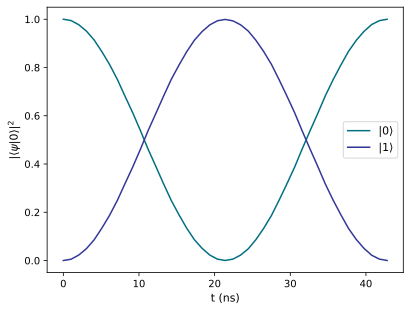

In [248]:
plt.plot(tlist, result.expect[0], label=r"$|0\rangle$")
plt.plot(tlist, result.expect[1], label=r"$|1\rangle$")
plt.xlabel(r"t (ns)")
plt.ylabel(r"$|\langle \psi |0\rangle|^2$");
plt.legend()

## Driving through the resonator
By using the charge operator for the resonator, transitions in the qubit can be driven through the resonator. Due to the weak coupling, this transition will occur more slowly than in driving the qubit directly.

In [250]:
#Hamiltonian is the interaction Hamiltonian plus the drive Hamiltonian 
H_osc_drive = [hamiltonian_trunc,[phi_r_trunc, drive_coeff]]

In [255]:
period = rabi_period(s0_idx, s1_idx, Omega, phi_r).real
tlist = np.linspace(0, period, round(period)) #Will take a longer time for the pi-pulse to complete
result = qt.sesolve(H_osc_drive, state0, tlist, e_ops = [state0*state0.dag(), state1*state1.dag()])

The same $\pi$ pulse will be effectuated on the qubit by the drive on the resonator, but the time the pulse takes is longer due to the smaller matrix element $\langle 00 | \hat \phi_{r} |10 \rangle$ compared to $\langle 00 | \hat n_\text{qbt} |10 \rangle$.

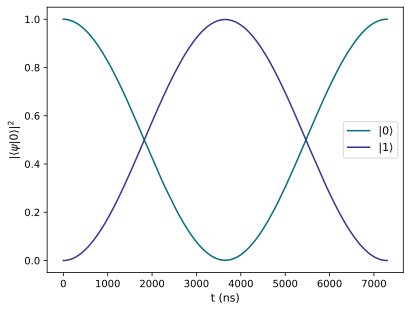

In [256]:
plt.plot(tlist, result.expect[0], label=r"$|0\rangle$")
plt.plot(tlist, result.expect[1], label=r"$|1\rangle$")
plt.xlabel(r"t (ns)")
plt.ylabel(r"$|\langle \psi |0\rangle|^2$");
plt.legend()